In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Dataset Definition

In [2]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, skip_empty=True):
        self.image_mask_pairs = []
        self.transform = transform
        self.skip_empty = skip_empty
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if not os.path.isdir(patient_path): continue
            for file in os.listdir(patient_path):
                if file.endswith(".tif") and "_mask" not in file:
                    img = os.path.join(patient_path, file)
                    msk = img.replace(".tif", "_mask.tif")
                    if os.path.exists(msk):
                        if self.skip_empty:
                            arr = np.array(Image.open(msk).convert("L"))
                            if arr.sum() == 0: continue
                        self.image_mask_pairs.append((img, msk))
    def __len__(self): return len(self.image_mask_pairs)
    def __getitem__(self, idx):
        img, msk = self.image_mask_pairs[idx]
        image = Image.open(img).convert("RGB")
        mask  = Image.open(msk).convert("L")
        if self.transform:
            image = self.transform(image)
            mask  = self.transform(mask)
        return image, (mask > 0).float()

print("step 1 done")

step 1 done


# # 2. Transforms & Loaders

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = BrainMRIDataset("/kaggle/input/lgg-mri-segmentation/kaggle_3m", transform)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("step 2 done")

step 2 done


# 3. U-Net

In [4]:
class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = UNetBlock(3, 64); self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256); self.enc4 = UNetBlock(256, 512)
        self.pool = nn.MaxPool2d(2); self.bottleneck = UNetBlock(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2); self.dec4 = UNetBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2); self.dec3 = UNetBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2); self.dec2 = UNetBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2);  self.dec1 = UNetBlock(128, 64)
        self.final = nn.Conv2d(64, 1, 1)
    def forward(self, x):
        e1 = self.enc1(x); e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2)); e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b); d4 = torch.cat([d4, e4], 1); d4 = self.dec4(d4)
        d3 = self.up3(d4); d3 = torch.cat([d3, e3], 1); d3 = self.dec3(d3)
        d2 = self.up2(d3); d2 = torch.cat([d2, e2], 1); d2 = self.dec2(d2)
        d1 = self.up1(d2); d1 = torch.cat([d1, e1], 1); d1 = self.dec1(d1)
        return self.final(d1)  # logits

print("step 3 done")

step 3 done


# # 4. MambaBlock

In [5]:
class MambaBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Conv2d(dim, dim, 1)
        self.A_d = nn.Conv2d(dim, dim, 3, padding=1)
        self.B_d = nn.Conv2d(dim, dim, 1)
        self.C = nn.Conv2d(dim, dim, 1)
        self.D = nn.Conv2d(dim, dim, 1)
        self.linear2 = nn.Conv2d(dim, dim, 1)
        self.norm = nn.BatchNorm2d(dim)
    def forward(self, u):
        x = F.relu(self.linear1(u))
        state = self.A_d(x) + self.B_d(u)
        out = self.C(state) + self.D(u)
        return self.linear2(self.norm(out))

print("step 4 done")

step 4 done


 # 5. Fixed MambaUNet

In [6]:
class MambaUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = MambaBlock(3);   self.enc_proj1 = nn.Conv2d(3, 64, 1)
        self.enc2 = MambaBlock(64);  self.enc_proj2 = nn.Conv2d(64, 128, 1)
        self.enc3 = MambaBlock(128); self.enc_proj3 = nn.Conv2d(128, 256, 1)
        self.enc4 = MambaBlock(256); self.enc_proj4 = nn.Conv2d(256, 512, 1)
        self.pool = nn.MaxPool2d(2)

        self.bottleneck = MambaBlock(512)

        self.up4 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec4 = MambaBlock(1024)

        self.up3 = nn.ConvTranspose2d(1024, 256, 2, 2)
        self.dec3 = MambaBlock(512)

        self.up2 = nn.ConvTranspose2d(512, 128, 2, 2)
        self.dec2 = MambaBlock(256)

        self.up1 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.dec1 = MambaBlock(128)

        self.out_proj = nn.Conv2d(128, 64, 1)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x, debug=False):
        if debug: print("Input:", x.shape)

        e1_raw = self.enc1(x)
        if debug: print("e1_raw:", e1_raw.shape)
        e1 = self.enc_proj1(e1_raw)
        if debug: print("e1:", e1.shape)

        e2_raw = self.enc2(self.pool(e1))
        if debug: print("e2_raw:", e2_raw.shape)
        e2 = self.enc_proj2(e2_raw)
        if debug: print("e2:", e2.shape)

        e3_raw = self.enc3(self.pool(e2))
        if debug: print("e3_raw:", e3_raw.shape)
        e3 = self.enc_proj3(e3_raw)
        if debug: print("e3:", e3.shape)

        e4_raw = self.enc4(self.pool(e3))
        if debug: print("e4_raw:", e4_raw.shape)
        e4 = self.enc_proj4(e4_raw)
        if debug: print("e4:", e4.shape)

        b = self.bottleneck(self.pool(e4))
        if debug: print("bottleneck:", b.shape)

        d4 = self.up4(b)
        if debug: print("up4:", d4.shape, "concat with e4:", e4.shape)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        if debug: print("dec4:", d4.shape)

        d3 = self.up3(d4)
        if debug: print("up3:", d3.shape, "concat with e3:", e3.shape)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        if debug: print("dec3:", d3.shape)

        d2 = self.up2(d3)
        if debug: print("up2:", d2.shape, "concat with e2:", e2.shape)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        if debug: print("dec2:", d2.shape)

        d1 = self.up1(d2)
        if debug: print("up1:", d1.shape, "concat with e1:", e1.shape)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        if debug: print("dec1:", d1.shape)

        out = self.out_proj(d1)
        if debug: print("out_proj:", out.shape)
        out = self.final(out)
        if debug: print("final out:", out.shape)

        return out


# 6. Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)
mamba = MambaUNet().to(device)

loss_fn = nn.BCEWithLogitsLoss()
opt_u = torch.optim.Adam(unet.parameters(), lr=1e-4)
opt_m = torch.optim.Adam(mamba.parameters(), lr=1e-4)
epochs = 1

print("step 6 done")

step 6 done


# Load Updated weights

In [8]:
# import os

# if os.path.exists("unet_weights.pth"):
#     unet.load_state_dict(torch.load("unet_weights.pth", map_location=device))
#     print("✅ Loaded UNet weights.")

# if os.path.exists("mamba_weights.pth"):
#     mamba.load_state_dict(torch.load("mamba_weights.pth", map_location=device))
#     print("✅ Loaded MambaUNet weights.")

# print("weights updated")

# 7. Metrics

In [9]:
def dice_score(preds, targets, th=0.5):
    preds = (torch.sigmoid(preds) > th).float()
    smooth = 1e-5
    inter = (preds * targets).sum(dim=(1, 2, 3))
    uni = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    return ((2 * inter + smooth) / (uni + smooth)).mean().item()

def iou_score(preds, targets, th=0.5):
    preds = (torch.sigmoid(preds) > th).float()
    inter = (preds * targets).sum(dim=(1, 2, 3))
    uni = ((preds + targets) > 0).sum(dim=(1, 2, 3))
    return ((inter + 1e-5) / (uni + 1e-5)).mean().item()

print("step 7 done")

step 7 done


# 8. Training loop

**With Updated Weights**

In [10]:
# for name, model, opt in [("UNet", unet, opt_u), ("Mamba", mamba, opt_m)]:
#     print(f"\n--- Training {name} ---")
#     for ep in range(epochs):
#         model.train()
#         tloss = 0
#         print(f"\nEpoch {ep+1} - Training phase")
        
#         for batch_idx, (imgs, msks) in enumerate(train_loader):
#             imgs, msks = imgs.to(device), msks.to(device)
#             is_last = (batch_idx == len(train_loader) - 1)

#             preds = model(imgs, debug=(name == "Mamba" and is_last)) if name == "Mamba" else model(imgs)
#             loss = loss_fn(preds, msks)
#             opt.zero_grad(); loss.backward(); opt.step()
#             tloss += loss.item()
            
#             if is_last:
#                 print(f"Train Batch {batch_idx+1}")
#                 print(f"Input imgs: {imgs.shape} Input masks: {msks.shape}")
#                 print(f"Preds shape: {preds.shape}")
#                 print(f"Loss: {loss.item()}\n")

#         model.eval()
#         d, i = 0, 0
#         print(f"Epoch {ep+1} - Validation phase")
#         for batch_idx, (imgs, msks) in enumerate(val_loader):
#             imgs, msks = imgs.to(device), msks.to(device)
#             is_last = (batch_idx == len(val_loader) - 1)

#             with torch.no_grad():
#                 pr = model(imgs, debug=(name == "Mamba" and is_last)) if name == "Mamba" else model(imgs)
#                 d += dice_score(pr, msks)
#                 i += iou_score(pr, msks)

#                 if is_last:
#                     print(f"Val Batch {batch_idx+1}")
#                     print(f"Input imgs: {imgs.shape} Input masks: {msks.shape}")
#                     print(f"Prediction shape: {pr.shape}")

#         print(f"✅ Ep{ep+1} | Loss={tloss/len(train_loader):.4f} | Dice={d/len(val_loader):.4f} | IoU={i/len(val_loader):.4f}")

#     # Save weights after training
#     if name == "UNet":
#         torch.save(model.state_dict(), "unet_weights.pth")
#         print("✅ UNet weights saved.")
#     else:
#         torch.save(model.state_dict(), "mamba_weights.pth")
#         print("✅ Mamba weights saved.")


In [11]:
for name, model, opt in [("UNet", unet, opt_u), ("Mamba", mamba, opt_m)]:
    print(f"\n--- Training {name} ---")
    for ep in range(epochs):
        model.train()
        tloss = 0
        print(f"\nEpoch {ep+1} - Training phase")
        
        for batch_idx, (imgs, msks) in enumerate(train_loader):
            imgs, msks = imgs.to(device), msks.to(device)
            is_last = (batch_idx == len(train_loader) - 1)

            preds = model(imgs, debug=(name == "Mamba" and is_last)) if name == "Mamba" else model(imgs)
            loss = loss_fn(preds, msks)
            opt.zero_grad(); loss.backward(); opt.step()
            tloss += loss.item()
            
            if is_last:
                print(f"Train Batch {batch_idx+1}")
                print(f"Input imgs: {imgs.shape} Input masks: {msks.shape}")
                print(f"Preds shape: {preds.shape}")
                print(f"Loss: {loss.item()}\n")

        model.eval()
        d, i = 0, 0
        print(f"Epoch {ep+1} - Validation phase")
        for batch_idx, (imgs, msks) in enumerate(val_loader):
            imgs, msks = imgs.to(device), msks.to(device)
            is_last = (batch_idx == len(val_loader) - 1)

            with torch.no_grad():
                pr = model(imgs, debug=(name == "Mamba" and is_last)) if name == "Mamba" else model(imgs)
                d += dice_score(pr, msks)
                i += iou_score(pr, msks)

                if is_last:
                    print(f"Val Batch {batch_idx+1}")
                    print(f"Input imgs: {imgs.shape} Input masks: {msks.shape}")
                    print(f"Prediction shape: {pr.shape}")

        print(f"✅ Ep{ep+1} | Loss={tloss/len(train_loader):.4f} | Dice={d/len(val_loader):.4f} | IoU={i/len(val_loader):.4f}")



--- Training UNet ---

Epoch 1 - Training phase
Train Batch 138
Input imgs: torch.Size([2, 3, 128, 128]) Input masks: torch.Size([2, 1, 128, 128])
Preds shape: torch.Size([2, 1, 128, 128])
Loss: 0.061749354004859924

Epoch 1 - Validation phase
Val Batch 35
Input imgs: torch.Size([3, 3, 128, 128]) Input masks: torch.Size([3, 1, 128, 128])
Prediction shape: torch.Size([3, 1, 128, 128])
✅ Ep1 | Loss=0.2231 | Dice=0.0000 | IoU=0.0000

--- Training Mamba ---

Epoch 1 - Training phase
Input: torch.Size([2, 3, 128, 128])
e1_raw: torch.Size([2, 3, 128, 128])
e1: torch.Size([2, 64, 128, 128])
e2_raw: torch.Size([2, 64, 64, 64])
e2: torch.Size([2, 128, 64, 64])
e3_raw: torch.Size([2, 128, 32, 32])
e3: torch.Size([2, 256, 32, 32])
e4_raw: torch.Size([2, 256, 16, 16])
e4: torch.Size([2, 512, 16, 16])
bottleneck: torch.Size([2, 512, 8, 8])
up4: torch.Size([2, 512, 16, 16]) concat with e4: torch.Size([2, 512, 16, 16])
dec4: torch.Size([2, 1024, 16, 16])
up3: torch.Size([2, 256, 32, 32]) concat with

# 9 Visualize

In [12]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_samples=3, threshold=0.5, model_name="Model"):
    model.eval()
    shown = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = torch.sigmoid(model(imgs)) > threshold

            for i in range(len(imgs)):
                if shown >= num_samples:
                    return

                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                mask = masks[i].cpu().squeeze().numpy()
                pred = preds[i].cpu().squeeze().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                fig.suptitle(f"{model_name} - Sample {shown+1}", fontsize=16)

                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(mask, cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(pred, cmap="gray")
                axs[2].set_title("Prediction")
                axs[2].axis("off")

                plt.tight_layout()
                plt.show()
                shown += 1


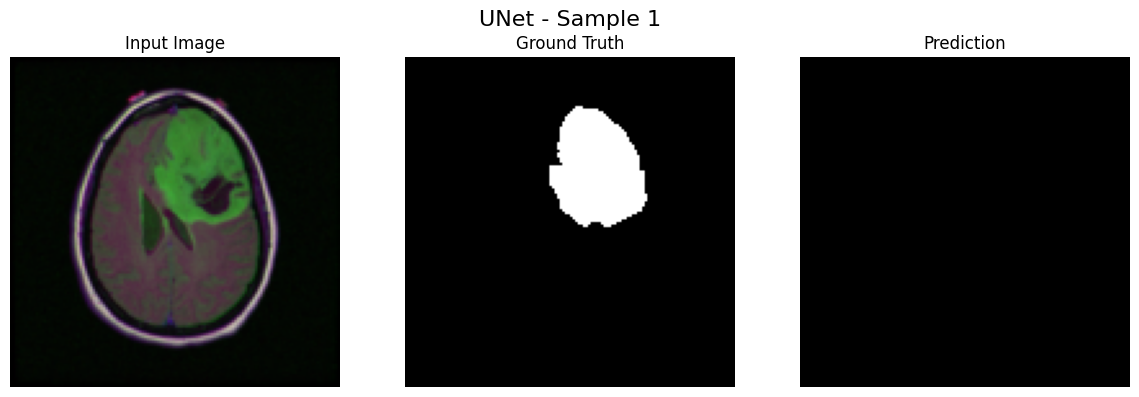

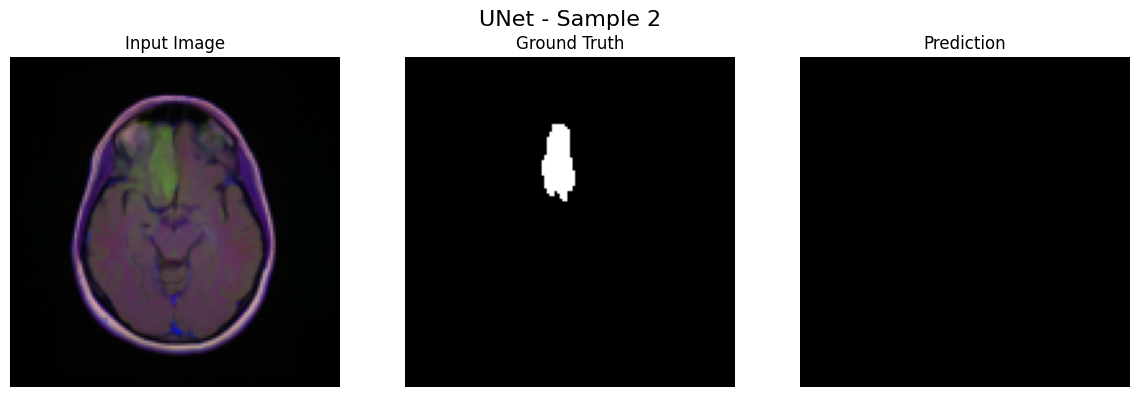

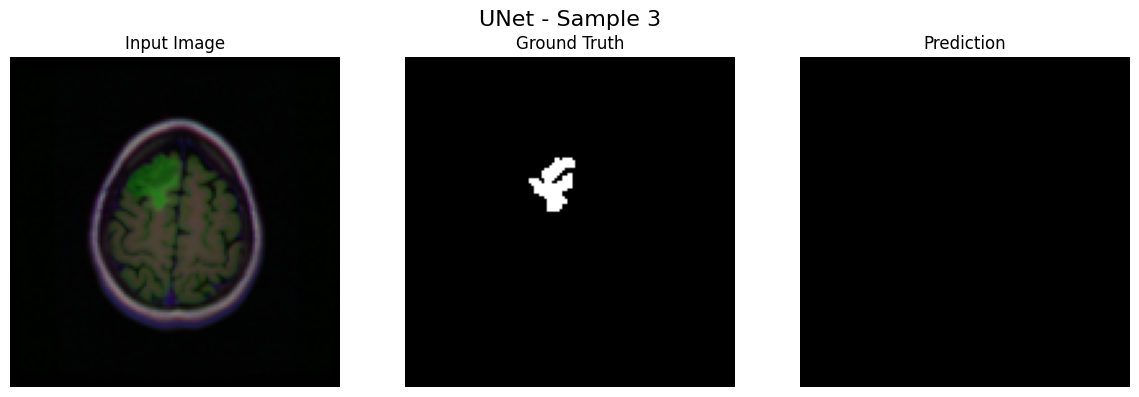

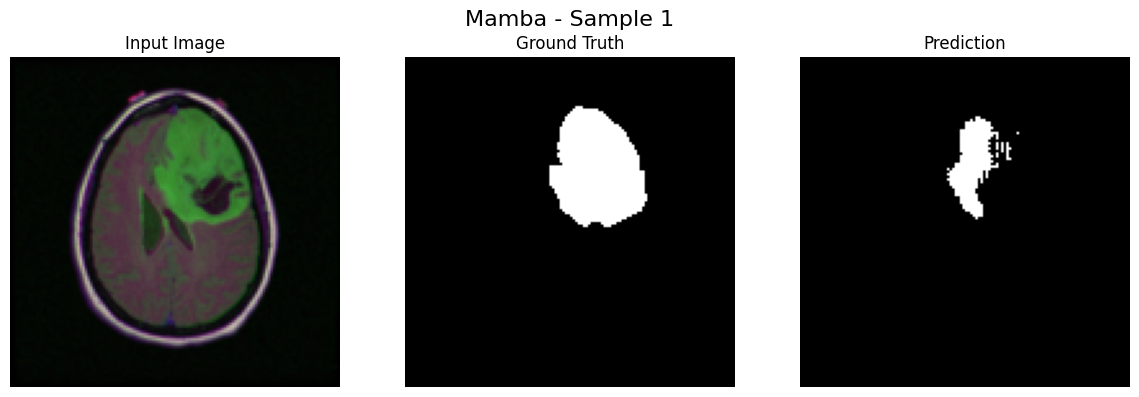

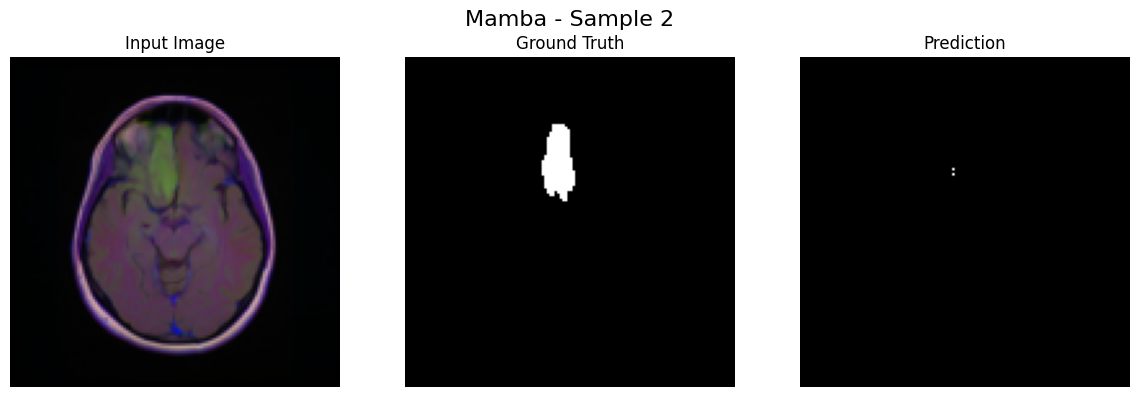

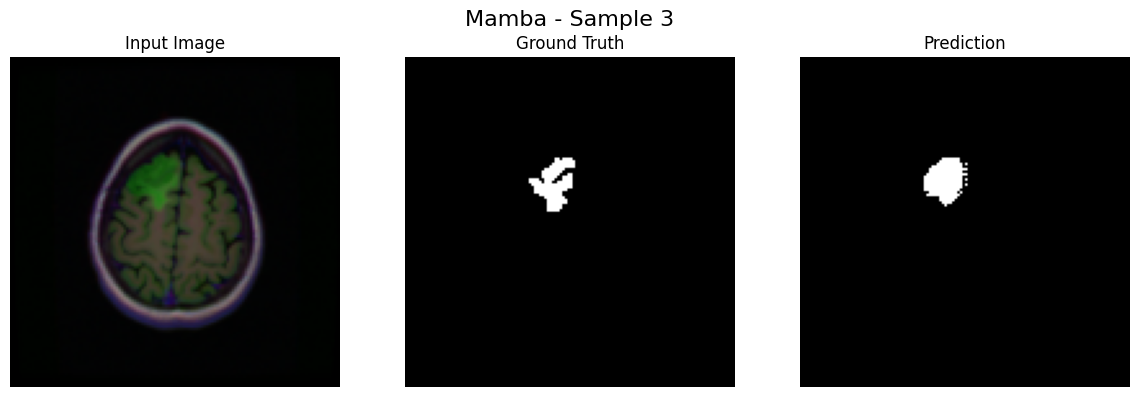

In [13]:
visualize_predictions(unet, val_loader, device, model_name="UNet")
visualize_predictions(mamba, val_loader, device, model_name="Mamba")


# Compare Performance

In [14]:
def evaluate_model(model, loader, device):
    model.eval()
    total_dice, total_iou = 0, 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            total_dice += dice_score(preds, masks)
            total_iou += iou_score(preds, masks)
    return total_dice / len(loader), total_iou / len(loader)

dice_u, iou_u = evaluate_model(unet, val_loader, device)
dice_m, iou_m = evaluate_model(mamba, val_loader, device)

print("\n🔍 Final Evaluation (Validation Set):")
print(f"UNet      -> Dice: {dice_u:.4f}, IoU: {iou_u:.4f}")
print(f"MambaUNet -> Dice: {dice_m:.4f}, IoU: {iou_m:.4f}")



🔍 Final Evaluation (Validation Set):
UNet      -> Dice: 0.0000, IoU: 0.0000
MambaUNet -> Dice: 0.2350, IoU: 0.1679


# Visualize Comparison Prediction

In [15]:
import matplotlib.pyplot as plt

def compare_models_visual(unet, mamba, dataloader, device, threshold=0.5, num_samples=3):
    unet.eval(); mamba.eval()
    shown = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds_u = torch.sigmoid(unet(imgs)) > threshold
            preds_m = torch.sigmoid(mamba(imgs)) > threshold

            for i in range(len(imgs)):
                if shown >= num_samples:
                    return

                img = imgs[i].cpu().permute(1, 2, 0).numpy()
                mask = masks[i].cpu().squeeze().numpy()
                pred_u = preds_u[i].cpu().squeeze().numpy()
                pred_m = preds_m[i].cpu().squeeze().numpy()

                fig, axs = plt.subplots(1, 4, figsize=(16, 4))
                fig.suptitle(f"Sample {shown+1}", fontsize=16)

                axs[0].imshow(img)
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(mask, cmap="gray")
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")

                axs[2].imshow(pred_u, cmap="gray")
                axs[2].set_title("UNet Prediction")
                axs[2].axis("off")

                axs[3].imshow(pred_m, cmap="gray")
                axs[3].set_title("Mamba Prediction")
                axs[3].axis("off")

                plt.tight_layout()
                plt.show()
                shown += 1


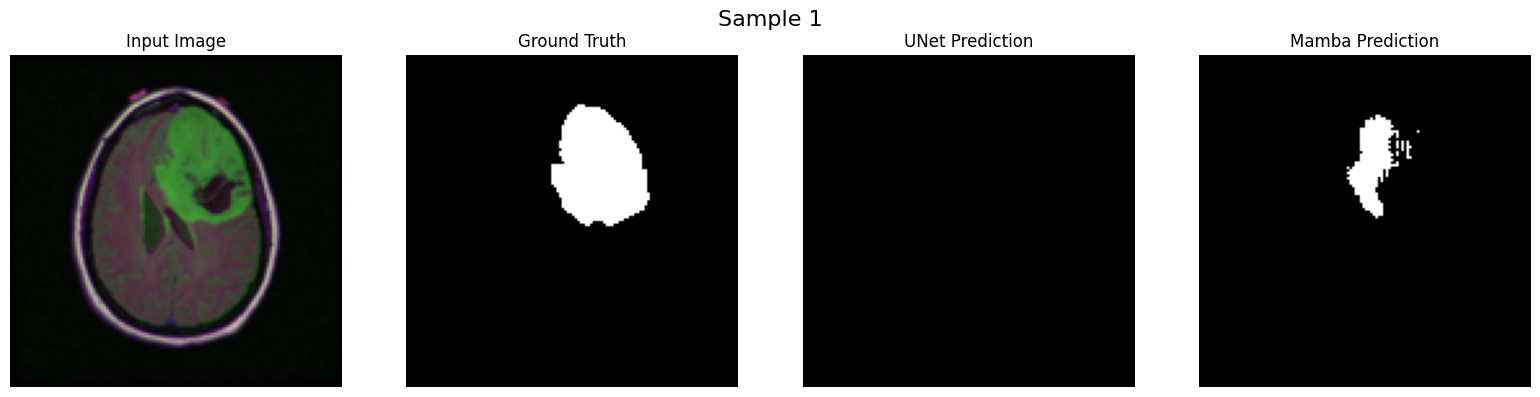

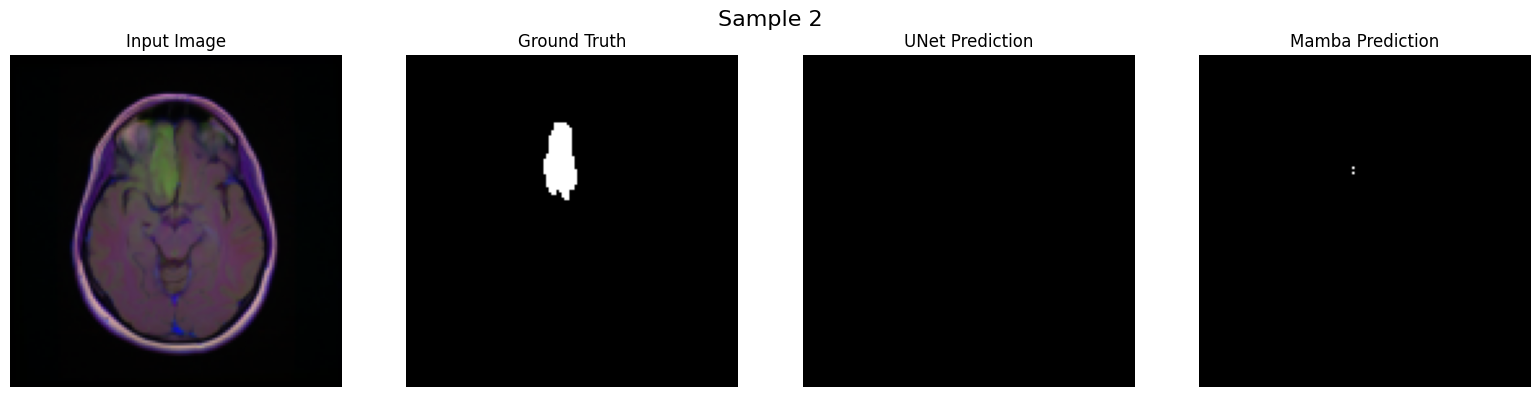

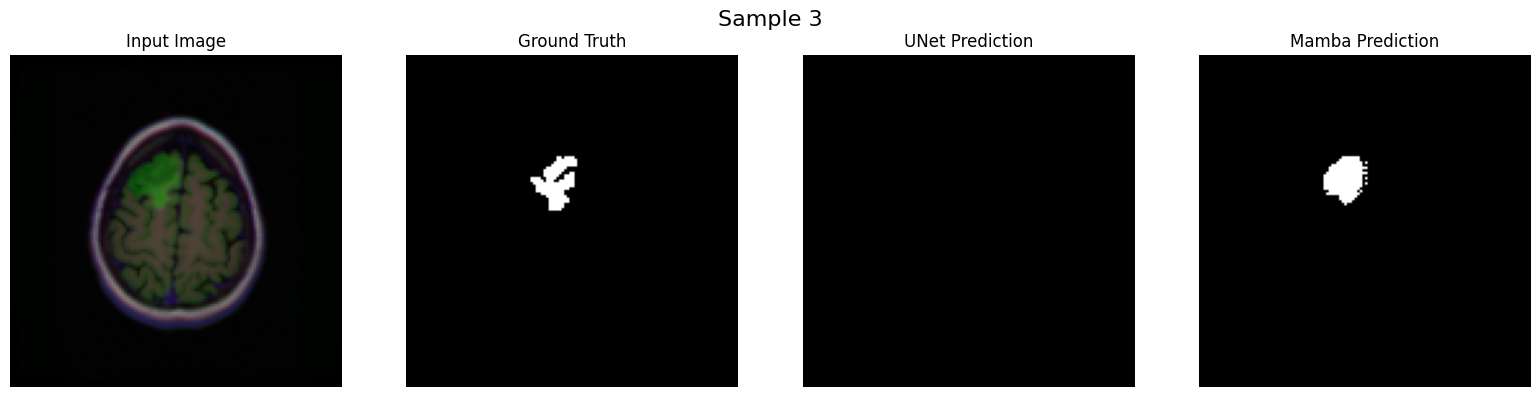

In [16]:
compare_models_visual(unet, mamba, val_loader, device)
